In [ ]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from liesel.contrib.splines import equidistant_knots as kn
from liesel.contrib.splines import pspline_penalty

from liesel_gam import MultivariateNormalSingular
from liesel_gam.experimental.approx_bspline import BSplineApprox

In [101]:
x_loc_true = jax.random.uniform(jax.random.key(43), (100,), minval=-2.0, maxval=2.0)
dist = tfd.MultivariateNormalDiag(loc=x_loc_true, scale_diag=jnp.ones(100))
x = dist.sample((5,), seed=jax.random.key(42))

knots = kn(jnp.array([-4.0, 4.0]), n_param=20)
bspline = BSplineApprox(knots)
coef = MultivariateNormalSingular(
    loc=jnp.zeros(20),
    scale=0.5,
    penalty=pspline_penalty(d=20),
    penalty_rank=18,
).sample(seed=jax.random.key(47))

obs_true = bspline.dot(x_loc_true, coef)
obs_true

obs = obs_true + 0.1 * jax.random.normal(jax.random.key(45), (100,))

In [102]:
coef

Array([-4.3033795, -2.4396653, -1.5253541, -0.1476832,  0.7527391,
        0.9197952,  1.405826 ,  1.7437729,  1.2276914,  1.2327771,
        1.1842926,  1.5778779,  2.1825225,  2.6411023,  2.045722 ,
        1.5687271,  0.1118217, -1.4771291, -3.419463 , -5.278081 ],      dtype=float32)

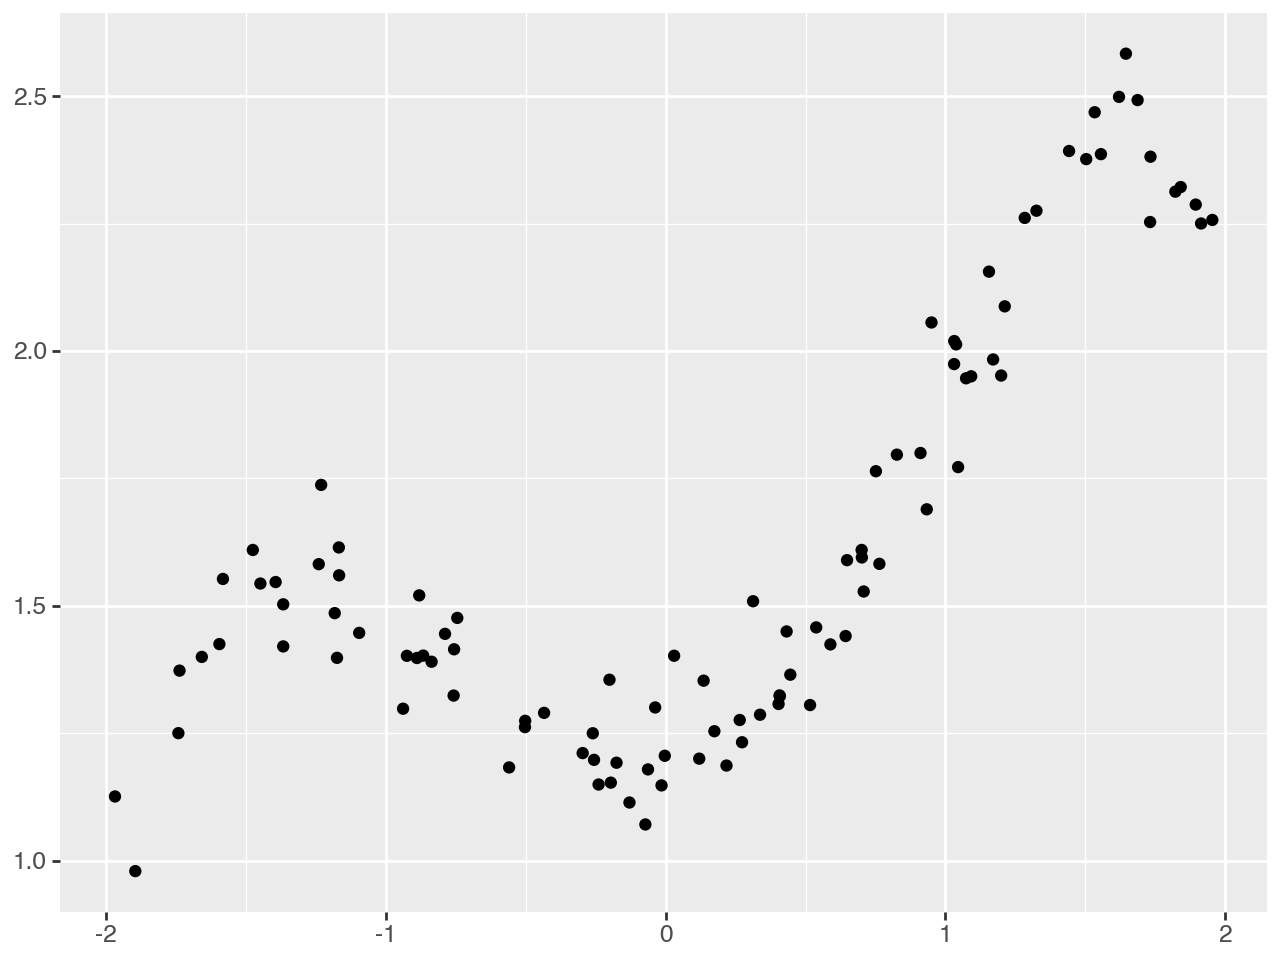

In [103]:
import plotnine as p9

(p9.ggplot() + p9.geom_point(p9.aes(x_loc_true, obs)))

In [104]:
x_loc = lsl.Var.new_param(
    jnp.zeros(100),
    name="xloc",
    inference=gs.MCMCSpec(gs.HMCKernel),
)
x_scale = lsl.Var.new_param(
    1.0,
    name="xscale",
    bijector=tfb.Exp(),
    inference=gs.MCMCSpec(gs.IWLSKernel),
)
x_var = lsl.Var.new_obs(
    value=x,
    distribution=lsl.Dist(tfd.Normal, loc=x_loc, scale=x_scale),
    name="x",
)

tau = lsl.Var.new_param(
    0.2,
    lsl.Dist(tfd.HalfNormal, scale=1.0),
    name="tau",
    bijector=tfb.Exp(),
    inference=gs.MCMCSpec(gs.IWLSKernel),
)
coef_var = lsl.Var.new_param(
    jnp.zeros(20),
    distribution=lsl.Dist(
        MultivariateNormalSingular,
        loc=jnp.zeros(20),
        scale=tau,
        penalty=pspline_penalty(d=20),
        penalty_rank=18,
    ),
    name="coef",
    inference=gs.MCMCSpec(gs.IWLSKernel),
)

bspline = BSplineApprox(knots)
fx_var = lsl.Var.new_calc(bspline.dot, x_loc, coef_var, name="fx")

scale_var = lsl.Var.new_param(
    1.0,
    lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01),
    name="scale",
    inference=gs.MCMCSpec(gs.IWLSKernel),
)
obs_var = lsl.Var.new_obs(
    obs, lsl.Dist(tfd.Normal, loc=fx_var, scale=scale_var), name="obs"
)

model = lsl.Model([x_var, obs_var])

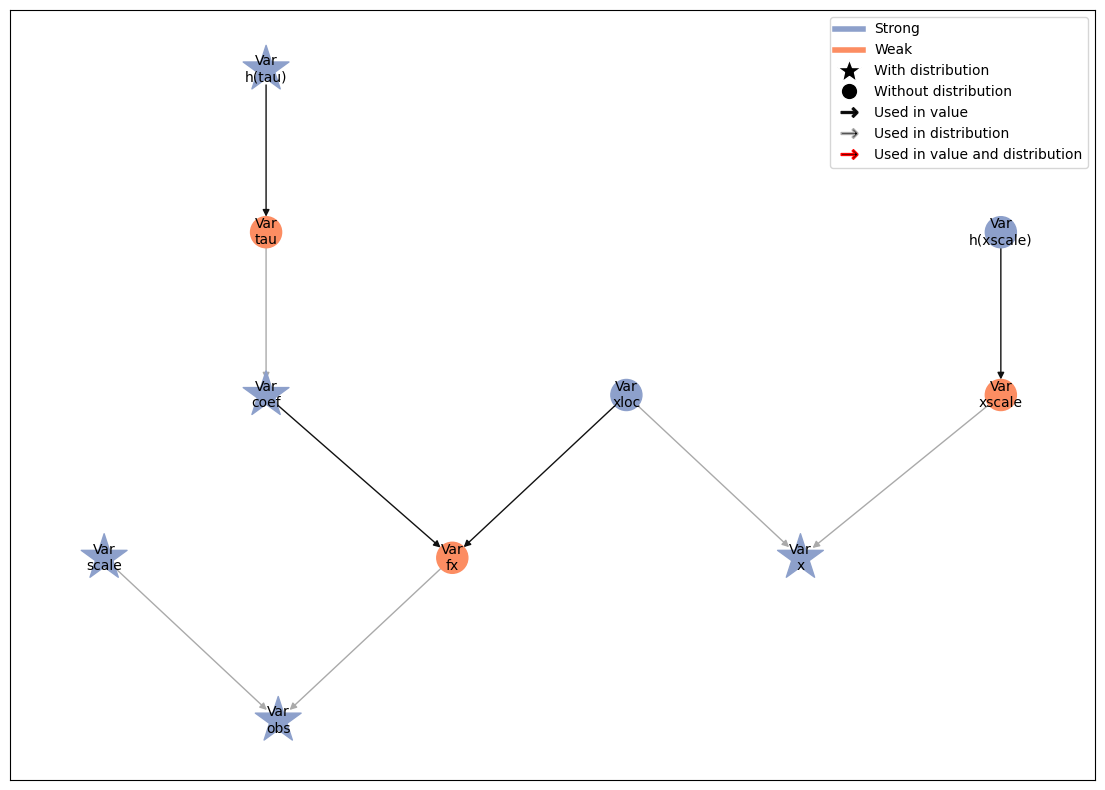

In [105]:
model.plot_vars()

In [106]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_adaptation(2000)
eb.add_posterior(20_000, thinning=20)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'scale', 'coef', 'h(tau)', 'xloc', 'h(xscale)'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:03<00:00,  2.12chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 45, 35, 61, 46 / 200 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 5, 2, 4, 4 / 200 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1321.04chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 0, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain f

In [107]:
summary = gs.Summary(results)
summary

Parameter summary:

                    kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter index                                                                
coef      (0,)   kernel_01 -1.114927  2.608864 -5.326726 -0.930711  2.694056   
          (1,)   kernel_01 -0.607655  1.841229 -3.682492 -0.444458  2.062001   
          (2,)   kernel_01 -0.099543  1.173097 -2.046400  0.026049  1.527959   
          (3,)   kernel_01  0.406471  0.647220 -0.763271  0.514950  1.204802   
          (4,)   kernel_01  0.904698  0.303236  0.362007  0.953234  1.293184   
...                    ...       ...       ...       ...       ...       ...   
xloc      (95,)  kernel_03  0.848743  0.126669  0.641811  0.849548  1.056200   
          (96,)  kernel_03 -0.040451  0.474592 -0.928906  0.110113  0.522205   
          (97,)  kernel_03  1.283295  0.280750  1.009241  1.228034  1.838193   
          (98,)  kernel_03  0.626509  0.158573  0.375885  0.635606  0.855372   
          (99,)  kernel_03 -0.228168  0.361342 -0.815301 -0.225793  0.319455   

                 sample_size     ess_bulk     ess_tail      rhat  
parameter index                                                   
coef      (0,)          4000  2562.717780  2609.824790  1.000570  
          (1,)          4000  2347.819875  2574.788036  1.000161  
          (2,)          4000  1902.137464  2269.178779  1.000677  
          (3,)          4000  1095.302897  1132.750849  1.002066  
          (4,)          4000   665.832677   723.638247  1.006643  
...                      ...          ...          ...       ...  
xloc      (95,)         4000  1327.954965  2598.731052  1.002986  
          (96,)         4000  2552.169746  2678.229570  1.000449  
          (97,)         4000  1049.225572   648.956058  1.003081  
          (98,)         4000  2068.578807  2745.380732  1.001223  
          (99,)         4000  3425.123025  3490.942961  1.000856  

[123 rows x 10 columns]

Error summary:

                                                                                  count  \
kernel    error_code error_msg                                          phase             
kernel_00 2          indefinite information matrix (fallback to iden... warmup      178   
                                                                        posterior     0   
          90         nan acceptance prob                                warmup       15   
                                                                        posterior     0   
          92         indefinite information matrix (fallback to iden... warmup        6   
                                                                        posterior     0   
kernel_02 90         nan acceptance prob                                warmup        1   
                                                                        posterior     0   
kernel_03 1          divergent transition                               warmup      153   
                                                                        posterior   864   

                                                                                  sample_size  \
kernel    error_code error_msg                                          phase                   
kernel_00 2          indefinite information matrix (fallback to iden... warmup           8000   
                                                                        posterior        4000   
          90         nan acceptance prob                                warmup           8000   
                                                                        posterior        4000   
          92         indefinite information matrix (fallback to iden... warmup           8000   
                                                                        posterior        4000   
kernel_02 90         nan acceptance prob                                warmup           8000   
                                                            

In [108]:
samples = results.get_posterior_samples()

In [109]:
fx_samp = fx_var.predict(samples)
x_loc_samp = x_loc.predict(samples)

In [110]:
fx_summary = gs.SamplesSummary.from_array(fx_samp).to_dataframe().reset_index()
x_loc_summary = gs.SamplesSummary.from_array(x_loc_samp).to_dataframe().reset_index()

In [111]:
fx_summary["x_true"] = x_loc_true
fx_summary["x_loc"] = x_loc_summary["mean"]
fx_summary["fx_true"] = obs_true

In [112]:
import plotnine as p9

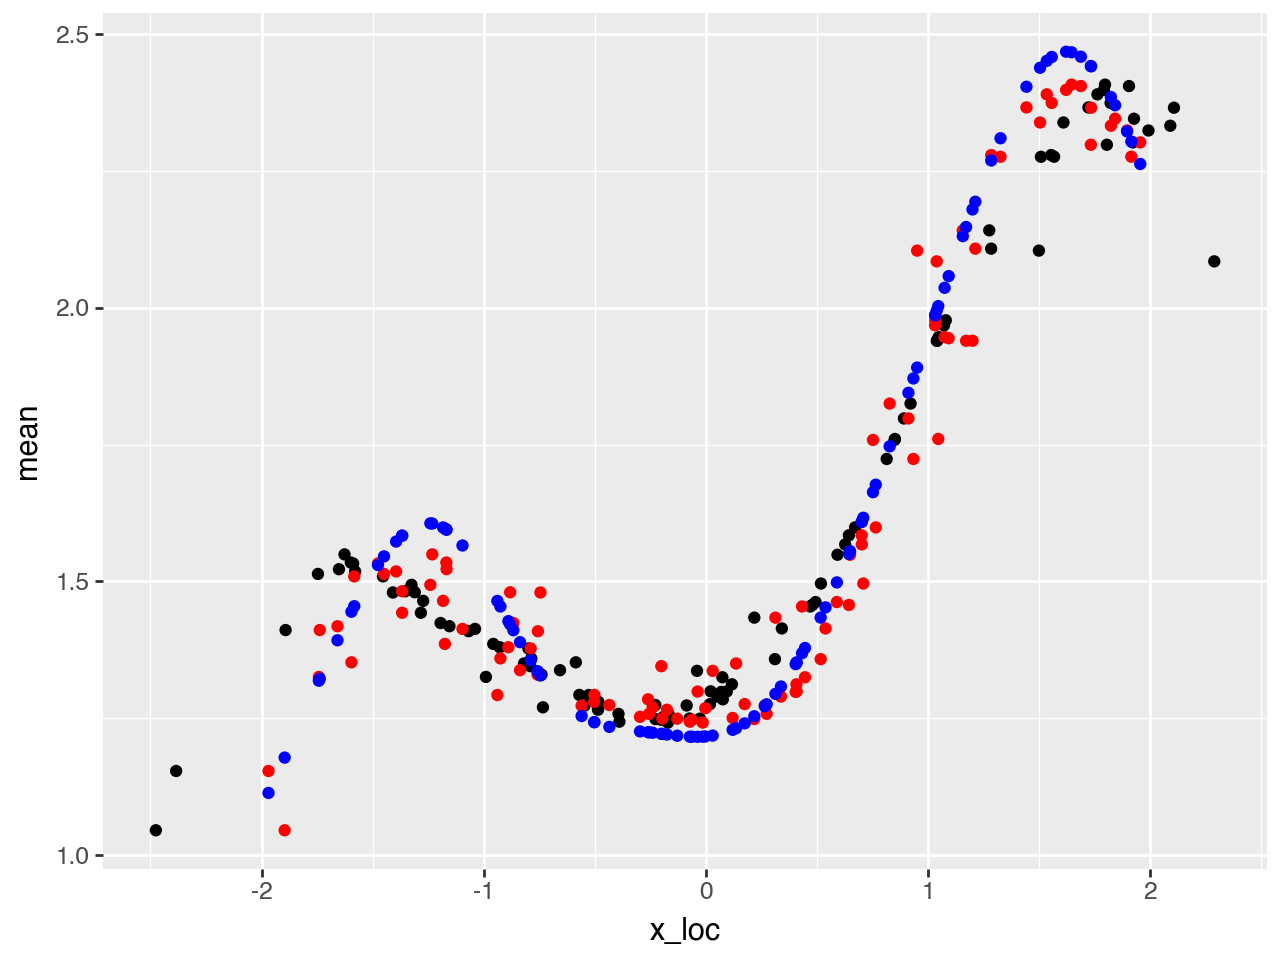

In [113]:
(
    p9.ggplot(fx_summary)
    + p9.geom_point(p9.aes("x_loc", "mean"))
    + p9.geom_point(p9.aes("x_true", "mean"), color="red")
    + p9.geom_point(p9.aes("x_true", "fx_true"), color="blue")
)